# Assignment 2 - MC906: Approximating images with 50 circles using Genetic Algorithm

## Problem modeling:

### Individual: an image with 50 circles

Each circle (gene) has the following parameters:
* left(float): distance to the left normalized between [0.0, 1.0]
* top(float): distance to the top normalized between [0.0, 1.0]
* radius(float): Circle radius
* color(array-like(h,s,v)): Color to be used on render coded as HSV
* alpha(float): Opacity level bound to [0.0, 1.0]

### Population: several sets with 50 circles each


In [ ]:
""" Circle plotting comparison """

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pat

FILL_CIRCLE = -1

fig, axs = plt.subplots(ncols=3, figsize=(15,5))

images = np.full(shape=(3, 500,500, 3), dtype=np.uint8, fill_value=255)
images[:, :250, :, :2] = 0
xy = (250, 250)
radius = 200
alpha = 0.5
color = (255, 0, 0)
norm_color = tuple(c/255 if c > 1 else c for c in color)

# Matplotlib.pyplot
image, ax = images[0], axs[0]
ax.add_artist(plt.Circle(xy, radius, facecolor=norm_color, alpha=alpha, antialiased=False))
ax.imshow(image)
ax.set_title('Matplotlib.pyplot')

# Matplotlib.patches
image, ax = images[1], axs[1]
ax.add_patch(pat.Circle(xy, radius, facecolor=norm_color, alpha=alpha, antialiased=False))
ax.imshow(image)
ax.set_title('Matplotlib.patches')

# OpenCV
# https://docs.opencv.org/2.4/modules/core/doc/drawing_functions.html#circle
image, ax = images[2], axs[2]
circle = np.copy(image)
cv2.circle(circle, center=xy, radius=radius, color=color, thickness=FILL_CIRCLE)
cv2.addWeighted(src1=circle, alpha=alpha, src2=image, beta=1-alpha, gamma=0, dst=image)
ax.imshow(image)
ax.set_title('OpenCV')

# fig.savefig('image', dpi=50)
plt.show()

## Useful links:

Aproximação por triangulos: https://github.com/DING-PENG/image-approx

## Indivíduos


<IPython.core.display.Javascript object>


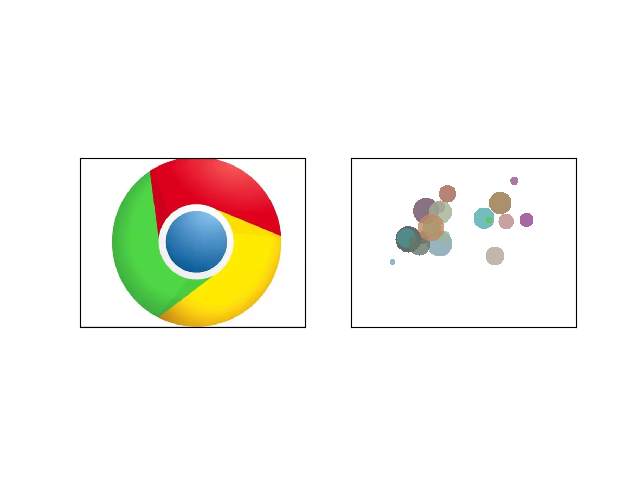

<IPython.core.display.Javascript object>


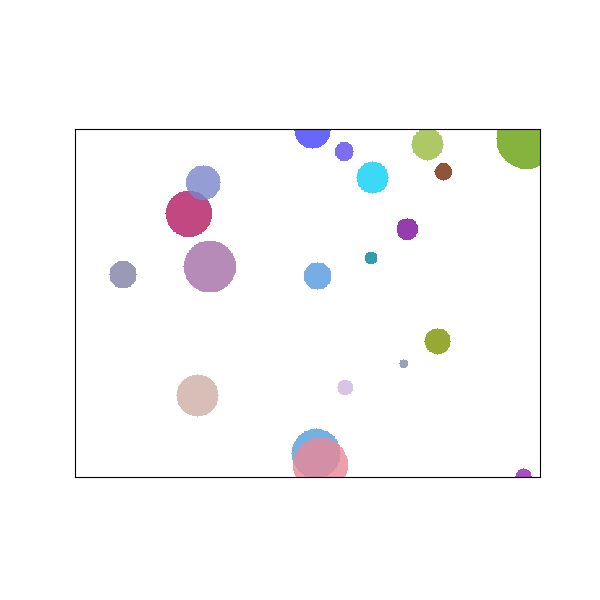

Gen: 0 Size: 20 Best: -0.6811287719874413 Mean: -0.6667043081574893


<IPython.core.display.Javascript object>


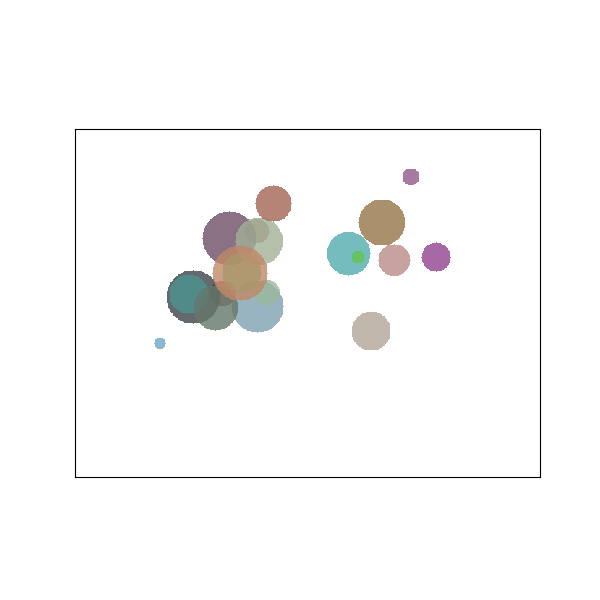

Gen: 11 Size: 20 Best: -0.6952588907742755 Mean: -0.6837009026080485
Enhanced by 0.0000000000


In [ ]:
%matplotlib notebook
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from time import time

from circle import Circle
from individual import Individual
from evolve import Evolve
from utils import rms, plot_image, save_image, create_weighted_hsv_ssim

from skimage.measure import compare_ssim
from IPython import display

plt.ion()

# Read reference image
image = cv2.imread('chrome.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)  # Convert color loaded by OpenCV

fig, axs = plt.subplots(1, 2)

plot_image(image, (fig, axs[0]))
plot_image(np.full(image.shape, fill_value=255, dtype=np.uint8), (fig, axs[1]))

def log_solution(i, solution, pop, end='\n'):
    print('Gen:', i, 'Size:', solution.ind_size,'Best:', solution.fitness, 'Mean:', np.mean([ind.fitness for ind in pop]), end=end)

# evolve = Evolve(image,
#                 pop_size=10,
#                 initial_pop=[],
#                 ind_size=100,
#                 ind_size_max=700,
#                 good_genes=True,
#                 fitness_function=create_weighted_hsv_ssim(),
#                 crossover_rate=0.9,
#                 newgen_parent_ratio=0.0,
#                 children_ratio=1,
#                 mutation_rate=0.3,
#                 inner_mutation_rate=1,
#                 unmutable_ratio=0.5)

evolve = Evolve(image,
                pop_size=20,
                initial_pop=[],
                ind_size=20,
                ind_size_max=100,
                good_genes=False,
#                 fitness_function=create_weighted_hsv_ssim((0.7, 0.1, 0.2)),
                fitness_function=Individual.get_fitness_function("SSIM_RGB"),
                crossover_rate=0.2,
                newgen_parent_ratio=1.0,
                children_ratio=1,
                mutation_rate=1.0,
                inner_mutation_rate=0.5,
                unmutable_ratio=1/20)

evolve.evaluate()
# print(evolve)
evolve.save_image('.')
evolve.plot_image((fig, axs[1]))
last_best = evolve.solution.fitness
log_solution(0, evolve.solution, evolve.pop)

since_enhancement = 0
since_print = 0

number_generations = 1000
# for i in range(1, number_generations):
i = 0
while True:
    i += 1
    evolve.crossover()
#     print(evolve)
    evolve.mutate(expand_step=1 if since_enhancement > 0 else 0)
    evolve.evaluate()
#     print(evolve)
    log_solution(i, evolve.solution, evolve.pop, end='\r')

    if last_best - evolve.solution.fitness > 0:
        since_enhancement = 0
        
        if since_print >= 10:
            since_print = 0
    #         print(evolve)
            evolve.save_image('.')
            axs[1].clear()
            evolve.plot_image((fig, axs[1]))
            last_best = evolve.solution.fitness        
            log_solution(i, evolve.solution, evolve.pop)
            print('Enhanced by {:.10f}'.format(last_best-evolve.solution.fitness))
        else:
            since_print += 1
    else:
        since_enhancement += 1
        since_print += 1
        
    if since_enhancement > 10:
        break